In [53]:
import os
import shutil
import pickle 
import spacy
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
import pandas as pd
import numpy as np
import spacy
import  pickle
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet
from gensim import corpora, models, similarities, downloader

C:\Users\pc\anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Exercise 3.1

In [3]:
PATH_DF = 'english_cleaned_lyrics.csv'
PATH_CORRECTION = 'indx2newdate.p'

def load_dataset(data_path, path_correction):
    df = pd.read_csv(data_path)
    indx2newdate = pickle.load(open(PATH_CORRECTION, 'rb'))
    df['year'] = df['index'].apply(lambda x: int(indx2newdate[x][0][:4]) if indx2newdate[x][0] != '' else 0)
    return df[df.year > 1960][['song', 'year', 'artist', 'genre', 'lyrics']]
    


In [4]:
dataset = load_dataset(PATH_DF, PATH_CORRECTION)

In [5]:
dataset.head()

song  year           artist genre  \
0                ego-remix  2009  beyonce-knowles   Pop   
5   all-i-could-do-was-cry  2008  beyonce-knowles   Pop   
6       once-in-a-lifetime  2008  beyonce-knowles   Pop   
9    why-don-t-you-love-me  2009  beyonce-knowles   Pop   
16                  poison  2009  beyonce-knowles   Pop   

                                               lyrics  
0   Oh baby how you doing You know I'm gonna cut r...  
5   I heard Church bells ringing I heard A choir s...  
6   This is just another day that I would spend Wa...  
9   N n now honey You better sit down and look aro...  
16  You're bad for me I clearly get it I don't see...

#### 3.1.1.Count how many songs of each genre are in the data set , and pick a genre

In [6]:
dataset['genre'].value_counts()

Rock          77556
Pop           23295
Metal         15671
Hip-Hop       14878
Country       10545
Electronic     5194
Jazz           5068
Indie          2489
Other          2449
R&B            2338
Folk           1373
Name: genre, dtype: int64

My choice will be Metal so i will create a subset containing only metal songs

In [7]:
df_metal = dataset[dataset.genre == 'Metal']

In [8]:
df_metal.head()

song  year   artist  genre  \
331            northern-hymn  2011  demonaz  Metal   
332    under-the-great-fires  2011  demonaz  Metal   
333        all-blackened-sky  2011  demonaz  Metal   
334  legends-of-fire-and-ice  2011  demonaz  Metal   
335            ode-to-battle  2011  demonaz  Metal   

                                                lyrics  
331  Gods Of The Mountains Sky Forest And Seas Land...  
332  Rise gods of the fierous black burning skies R...  
333  A Dying Skyline Cold From Wind And Rain Autumn...  
334  Fiends of the gods to war we ride Over the bla...  
335  Cold Is The Winter On Its Ground We Ride To Th...

In [9]:
df_metal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15671 entries, 331 to 217983
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   song    15671 non-null  object
 1   year    15671 non-null  int64 
 2   artist  15671 non-null  object
 3   genre   15671 non-null  object
 4   lyrics  15671 non-null  object
dtypes: int64(1), object(4)
memory usage: 734.6+ KB


#### 3.1.2.Inspect the number of songs for each year

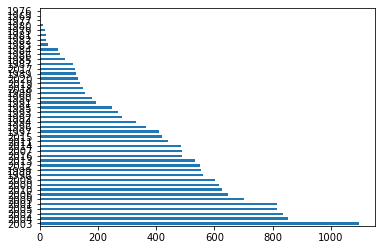

In [10]:
df_metal['year'].value_counts().plot(kind='barh')

In [11]:
df_metal['year'].value_counts()

2003    1095
2004     852
2002     835
2005     816
2001     814
2009     703
2006     647
2010     625
2000     617
2008     602
1998     561
1999     555
2012     549
2013     535
2016     487
2007     487
2014     486
2011     441
2015     421
1997     408
1996     366
1994     331
1992     283
1993     270
1995     249
1991     195
1990     181
1988     156
2018     149
2019     139
2020     130
1989     125
2017     122
1987     115
1985      88
1986      71
1984      63
1983      29
1982      20
1981      20
1979      17
1980      12
1977       2
1969       1
1976       1
Name: year, dtype: int64

In [12]:
years_of_metal = df_metal['year'].unique()

Some of the years has less than 50 songs so we are going to use the years with more that 50 songs 

In [13]:
year_songs_count = []
for year in years_of_metal:
    year_songs_count.append({
        'Year': year,
        'Count': len(df_metal[df_metal['year']==year])
    })
df_metal_years = pd.DataFrame(year_songs_count)

In [14]:
df_metal_years.sort_values(by=['Year'])
metal_years_more_than_fifty = df_metal_years[df_metal_years['Count'] >= 50]

In [15]:
metal_years_more_than_fifty

Year  Count
0   2011    441
1   2009    703
2   1999    555
3   2004    852
4   1998    561
5   2012    549
6   2000    617
7   2013    535
8   2015    421
9   2014    486
10  2010    625
11  2005    816
12  2002    835
13  2001    814
14  1997    408
15  1995    249
16  2006    647
17  2008    602
18  1996    366
19  2007    487
20  1994    331
21  2018    149
22  2003   1095
23  2016    487
24  2019    139
25  1993    270
26  1992    283
27  2017    122
28  2020    130
29  1987    115
30  1989    125
31  1990    181
32  1988    156
33  1991    195
36  1985     88
38  1986     71
40  1984     63

In [16]:
years_to_keep = list(metal_years_more_than_fifty['Year'].values)
print(years_to_keep)
for year in years_to_keep:
    df_metal[df_metal['year'] != year] # we exclude the years we saw less than 50 songs
    
print(df_metal)
    

[2011, 2009, 1999, 2004, 1998, 2012, 2000, 2013, 2015, 2014, 2010, 2005, 2002, 2001, 1997, 1995, 2006, 2008, 1996, 2007, 1994, 2018, 2003, 2016, 2019, 1993, 1992, 2017, 2020, 1987, 1989, 1990, 1988, 1991, 1985, 1986, 1984]
                                 song  year     artist  genre  \
331                     northern-hymn  2011    demonaz  Metal   
332             under-the-great-fires  2011    demonaz  Metal   
333                 all-blackened-sky  2011    demonaz  Metal   
334           legends-of-fire-and-ice  2011    demonaz  Metal   
335                     ode-to-battle  2011    demonaz  Metal   
...                               ...   ...        ...    ...   
217132                           time  2019  even-song  Metal   
217144                         sunset  1991  even-song  Metal   
217981  clenched-fists-of-desperation  2004  anam-cara  Metal   
217982       written-on-a-cavern-wall  2004  anam-cara  Metal   
217983                a-new-sun-rises  2004  anam-cara  Metal 

#### 3.1.3.Process  the  texts  of  your  genre

In [17]:
nlp = spacy.load("en_core_web_sm")

In [18]:
texts = df_metal['lyrics']
texts


331       Gods Of The Mountains Sky Forest And Seas Land...
332       Rise gods of the fierous black burning skies R...
333       A Dying Skyline Cold From Wind And Rain Autumn...
334       Fiends of the gods to war we ride Over the bla...
335       Cold Is The Winter On Its Ground We Ride To Th...
                                ...                        
217132     Unfathomable Sea whose waves are years Ocean ...
217144    Beyond the heaven's warm and velvet mist woune...
217981    i've seen that twitch in your eye before you c...
217982    cut the bonds between us let them tie the noos...
217983    waking restless and alive these thoughts stifl...
Name: lyrics, Length: 15671, dtype: object

Now we lemmatize tokens for each song and we will remove stop words

In [19]:
data_excl_punc_stop_words = df_metal['lyrics'].progress_apply(lambda x: [y.lemma_ for y in nlp(x) if not y.is_punct and not y.is_stop])

In [20]:
print(data_excl_punc_stop_words)

331       [god, Mountains, Sky, Forest, Seas, Lands, Fir...
332       [rise, god, fierous, black, burn, sky, raise, ...
333       [die, Skyline, Cold, Wind, Rain, Autumn, Darkn...
334       [fiend, god, war, ride, black, mountain, far, ...
335       [Cold, winter, ground, ride, Battlefield, Batt...
                                ...                        
217132    [ , Unfathomable, Sea, wave, year, Ocean, Time...
217144    [heaven, warm, velvet, mist, wounede, thorn, e...
217981    [see, twitch, eye, push, away, word, advice, w...
217982    [cut, bond, let, tie, noose, lynch, heartless,...
217983    [wake, restless, alive, thought, stifle, time,...
Name: lyrics, Length: 15671, dtype: object


In [21]:
#from tqdm import tqdm_notebook # if you use notebooks, import tqdm_notebook instead

#processed_texts = [text for text in tqdm_notebook(nlp.pipe(texts, 
#                                              n_process=-1, # maximum number of threads
#                                              disable=["ner",
#                                                       "parser"]),
#                                          total=len(texts))]


In [22]:
##A now the thing we'd like to do, like tokenization:

#tokenized_texts = [[word.text for word in text if not word.is_punct] 
#                    for text in processed_texts]
#print(tokenized_texts)

#### 3.1.4.Create a dictionary

In [23]:
tokenized_texts = data_excl_punc_stop_words

In [24]:
from gensim.corpora import Dictionary

MIN_DF = 3 # minium document frequency
MAX_DF = 0.85 # maximum document frequency


In [25]:
dictionary = Dictionary(tokenized_texts) # get the vocabulary
dictionary.filter_extremes(no_below=MIN_DF, 
                           no_above=MAX_DF)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

In [26]:
print(corpus)


[[(0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (12, 2), (13, 2), (14, 2), (15, 2), (16, 2)], [(12, 2), (13, 3), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 2), (37, 1), (38, 1), (39, 2), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 13), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 7), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 4), (61, 5), (62, 4), (63, 1), (64, 1), (65, 2), (66, 1), (67, 1), (68, 7), (69, 1), (70, 3), (71, 1), (72, 1), (73, 2), (74, 1), (75, 2), (76, 1), (77, 1), (78, 2), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 3)], [(0, 1), (6, 1), (12, 1), (13, 1), (14, 1), (16, 1), (33, 1), (34, 1), (35, 1), (37, 1), (45, 2), (47, 1), (73, 1), (85, 2), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 2), (95, 1

#### 3.1.5 Train a topic model with 50 topics

In [45]:
PATH_TO_MALLET = 'C:/mallet/bin/mallet'
N_ITERATIONS = 1000
N_TOPICS = [20,50,100]

if os.path.exists('lda_models'):
     shutil.rmtree('lda_models')
os.makedirs('lda_models')

for topic in N_TOPICS:
     print(f'lda_models/{topic}')
     lda = LdaMallet(PATH_TO_MALLET,
                 corpus=corpus,
                 id2word=dictionary,
                 num_topics=20,
                 iterations=N_ITERATIONS) 
     lda.save(f'lda_models/{topic}.model')

lda_models/20
lda_models/50
lda_models/100


In [49]:
import pyLDAvis

In [54]:
lda_50 = models.ldamodel.LdaModel.load('lda_models/50.model')
lda_20 = models.ldamodel.LdaModel.load('lda_models/20.model')
lda_100 = models.ldamodel.LdaModel.load('lda_models/100.model')

In [55]:
TOPIC = 0 #to see for the first one only
MAX_WORDS = 10
words_lda_20 = lda_20.show_topic(TOPIC, MAX_WORDS) 
print(words_lda_20)

[('eye', 0.09330599091841218), ('dream', 0.08519481470631317), ('fall', 0.0773399736340999), ('tear', 0.05626556320492163), ('cry', 0.04950930130364728), ('hear', 0.038743225428445875), ('fear', 0.029936282408085543), ('close', 0.029753185879595724), ('sleep', 0.028398271568771057), ('voice', 0.024113812802109273)]


In [56]:
TOPIC = 0 #to see for the first one only
MAX_WORDS = 10
words_lda_50 = lda_50.show_topic(TOPIC, MAX_WORDS) 
print(words_lda_50)

[('thing', 0.05671869052150742), ('good', 0.03947468595355919), ('run', 0.03793300342596117), ('stop', 0.03460220784164446), ('stay', 0.0323943661971831), ('hard', 0.028892272554244387), ('start', 0.028340312143129046), ('wrong', 0.027521888085268367), ('change', 0.026665397792158357), ('care', 0.025618576322801675)]


In [57]:
TOPIC = 0 #to see for the first one only
MAX_WORDS = 10
words_lda_100 = lda_100.show_topic(TOPIC, MAX_WORDS) 
print(words_lda_100)

[('mind', 0.10502364770875561), ('world', 0.09627995707642781), ('inside', 0.08121696275982672), ('break', 0.030523429116489805), ('fear', 0.026290687969476572), ('control', 0.02569452724454513), ('hide', 0.021998330749970194), ('blind', 0.019852152140217003), ('escape', 0.016891220539724177), ('open', 0.016473908032272166)]


I think i will choose the words_lda_20 because most of the words are most known by me in all the metal songs that i ve heard before

In [61]:
#may i could do it without run this again but i saw it afterwards
PATH_TO_MALLET = 'C:/mallet/bin/mallet'
N_TOPICS = 20
N_ITERATIONS = 1000

lda = LdaMallet(PATH_TO_MALLET,
                corpus=corpus,
                id2word=dictionary,
                num_topics=N_TOPICS,
                iterations=N_ITERATIONS)

In [62]:
for topic in range(N_TOPICS): #thats for the first 20
    words = lda.show_topic(topic, 10)
    topic_n_words = ' '.join([word[0] for word in words])
    print('Topic {}: {}'.format(str(topic), topic_n_words))

Topic 0: black curse spirit thy great ancient beauty spell secret beast
Topic 1: fuck yeah wanna shit baby -PRON- bitch hey Chorus talk
Topic 2: night light dark darkness cold shadow silence soul fall shine
Topic 3: blood flesh body skin bone dead rot eat rip corpse
Topic 4: turn face hand run man walk stand line head step
Topic 5: world dream eye free mind hear open forever fly follow
Topic 6: burn fire hell god God evil flame sin soul demon
Topic 7: fight land war rise ride power blood high stand king
Topic 8: thing stop good word wrong care change hard understand learn
Topic 9: die death pain soul fear hate bring life scream cry
Topic 10: life live lie truth give word find hope reason speak
Topic 11: sky star black sea sun wind dance rain red eye
Topic 12: mind thought sense existence reality state vision create blind lead
Topic 13: time end day lose past year memory begin moment pass
Topic 14: leave long find wait hold home stay save remember place
Topic 15: inside dead break alive

In [66]:
import gensim

import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()



In [69]:
lda_conv = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_20)

In [ ]:
pyLDAvis.gensim.prepare(lda_conv, corpus, dictionary)

#### 3.1.6.Make  a  change  in  the  preprocessing  stage

In [71]:
data_excl_punc_stop_words_adj = df_metal['lyrics'].progress_apply(lambda x: [y.lemma_ for y in nlp(x) if not y.is_punct and not y.is_stop and not y.pos_ == "ADJ"])

In [72]:
tokenized_texts_excl_adj = data_excl_punc_stop_words_adj
dictionary = Dictionary(tokenized_texts_excl_adj) # get the vocabulary
dictionary.filter_extremes(no_below=MIN_DF, 
                           no_above=MAX_DF)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts_excl_adj]

In [74]:
# we will now do the same as before to see if there is an actual differnece
PATH_TO_MALLET = 'C:/mallet/bin/mallet'
N_ITERATIONS = 1000
N_TOPICS = [20,50]

if os.path.exists('lda_models_excl_adj'):
    shutil.rmtree('lda_models_excl_adj')
os.makedirs('lda_models_excl_adj')

for topic in N_TOPICS:
    print(f'lda_models_excl_adj/{topic}')
    lda = LdaMallet(PATH_TO_MALLET,
                corpus=corpus,
                id2word=dictionary,
                num_topics=20,
                iterations=N_ITERATIONS) 
    lda.save(f'lda_models_excl_adj/{topic}.model')

lda_models_excl_adj/20
lda_models_excl_adj/50


In [75]:
lda_20_excl_adj = models.ldamodel.LdaModel.load('lda_models_excl_adj/20.model')
lda_50_excl_adj = models.ldamodel.LdaModel.load('lda_models_excl_adj/50.model')

In [77]:
words_lda_20_excl_adj = lda_20_excl_adj.show_topic(TOPIC, MAX_WORDS) 
print(words_lda_20_excl_adj)

[('fuck', 0.024737273099495017), ('shit', 0.022246485601201037), ('-PRON-', 0.013955234065784087), ('hit', 0.011549747509212501), ('bitch', 0.01059437696192166), ('money', 0.010509076020199263), ('hey', 0.010321413948409991), ('rock', 0.009929029616486966), ('boy', 0.009639006414630818), ('ya', 0.008888358127473727)]


In [78]:
words_lda_50_excl_adj = lda_50_excl_adj.show_topic(TOPIC, MAX_WORDS)
print(words_lda_50_excl_adj)

[('world', 0.1555360077779578), ('end', 0.12322044491770642), ('bring', 0.05581147711752587), ('hope', 0.038959235167480726), ('save', 0.03590360887983518), ('set', 0.03296372601217621), ('begin', 0.031898886548299726), ('rest', 0.024583902405148267), ('year', 0.020347693233639667), ('suffer', 0.01967638139771754)]


In [82]:
for topic in range(11):
    words_20_excl_adj = lda_20_excl_adj.show_topic(topic, 10)
    topic_n_words = ' '.join([word[0] for word in words_20_excl_adj])
    print('Topic {}: {}'.format(str(topic), topic_n_words))

Topic 0: fuck shit -PRON- hit bitch money hey rock boy ya
Topic 1: land ride man power king battle thousand sword sea storm
Topic 2: night light sky sun fly darkness star wind shine wing
Topic 3: mind find inside lie lose hide truth hope fear open
Topic 4: time day dream wait forever forget sleep remember fade memory
Topic 5: turn run break time thing change stop start care step
Topic 6: burn soul fire hell rise flame save set demon return
Topic 7: bleed breathe breath cut eye skin pull head wound bury
Topic 8: die kill fight bring death war fear destroy bear win
Topic 9: eye face stand hand place hold walk watch head wall
Topic 10: people play pay game fool control rule sell race kind


In [83]:
for topic in range(11):
    words_50_excl_adj = lda_50_excl_adj.show_topic(topic, 10)
    topic_n_words = ' '.join([word[0] for word in words_50_excl_adj])
    print('Topic {}: {}'.format(str(topic), topic_n_words))

Topic 0: world end bring hope save set begin rest year suffer
Topic 1: time stand change forget thing care reason line learn understand
Topic 2: find lose truth place reach silence fear path search lead
Topic 3: eye dream walk forever close sleep follow fade memory open
Topic 4: fall tear lie cry watch call rain bleed eye breath
Topic 5: earth water sea stone flow wave ocean river secret beneath
Topic 6: night light sun shadow star darkness shine moon sky dance
Topic 7: run stop yeah hear start tonight play wanna song sing
Topic 8: leave turn hand break word hold face wall speak promise
Topic 9: control mind force create state machine reality existence breed thought
Topic 10: death soul hell angel demon evil darkness desire curse beast


For me the words that i have now they are more intense describing what metal is better in my opinion.Some strong feelings with words like darkness wich is always part of the metal.
One benefit of removing adjectives is that they are really generic words like 'thing' been used and had nothing tosay as a word and sometimes for me they are even vague
One downside is even most of the times those words are vague they add something to the song or the feeling you get so we have to be carefull with the preprocessing that we are going to use, also we have to know the audience or the reason we are doing the research in order to make the 'best' decission 

#### 3.1.7.Choose your best topic mode

50 Excluding adj works better for me 20,100 i think they have way more outeside metal stuff in my opinion
Also prominent topics are emotions(fear),states of the mind and maybe earth and heaven

#### 3.1.8.Look at the topics

In [86]:
metadata = dataset

In [87]:
transformed_docs = lda_50_excl_adj.load_document_topics()
topic_distributions = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs], 
             columns=['topic_{}'.format(i) for i in range(20)])
topic_distributions.head()

topic_0   topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  \
0  0.030488  0.030488  0.030488  0.030488  0.030488  0.067073  0.054878   
1  0.029221  0.048701  0.016234  0.029221  0.016234  0.016234  0.035714   
2  0.043689  0.024272  0.024272  0.024272  0.033981  0.043689  0.072816   
3  0.036765  0.036765  0.036765  0.036765  0.036765  0.051471  0.036765   
4  0.040984  0.040984  0.040984  0.040984  0.040984  0.040984  0.073770   

    topic_7   topic_8   topic_9  topic_10  topic_11  topic_12  topic_13  \
0  0.030488  0.030488  0.030488  0.030488  0.030488  0.054878  0.030488   
1  0.016234  0.035714  0.016234  0.016234  0.016234  0.035714  0.022727   
2  0.024272  0.024272  0.033981  0.063107  0.024272  0.043689  0.033981   
3  0.036765  0.051471  0.036765  0.036765  0.036765  0.051471  0.036765   
4  0.040984  0.073770  0.040984  0.040984  0.040984  0.040984  0.040984   

   topic_14  topic_15  topic_16  topic_17  topic_18  topic_19  
0  0.030488  0.042683  0.030488  0.030488  0.030488  0.323171  
1  0.035714  0.016234  0.022727  0.139610  0.016234  0.418831  
2  0.033981  0.024272  0.024272  0.033981  0.024272  0.344660  
3  0.036765  0.036765  0.036765  0.066176  0.036765  0.227941  
4  0.040984  0.040984  0.040984  0.073770  0.040984  0.122951

In [88]:
joined_topic_dist = metadata.reset_index().join(topic_distributions)

In [89]:
print(joined_topic_dist)

         index                       song  year           artist    genre  \
0            0                  ego-remix  2009  beyonce-knowles      Pop   
1            5     all-i-could-do-was-cry  2008  beyonce-knowles      Pop   
2            6         once-in-a-lifetime  2008  beyonce-knowles      Pop   
3            9      why-don-t-you-love-me  2009  beyonce-knowles      Pop   
4           16                     poison  2009  beyonce-knowles      Pop   
...        ...                        ...   ...              ...      ...   
160851  218204               swingin-door  2012       edens-edge  Country   
160852  218205  who-am-i-drinking-tonight  2012       edens-edge  Country   
160853  218206                       liar  2012       edens-edge  Country   
160854  218207                last-supper  2012       edens-edge  Country   
160855  218209                       amen  2012       edens-edge  Country   

                                                   lyrics   topic_0   topic

In [90]:
grouped_by_year = joined_topic_dist.groupby('year').mean()

In [91]:
def get_trends(X,Y, order=1):
    result = np.polyfit(X, list(Y), order)
    slope = result[-2]
    return float(slope)

trends = []
for i in range(20):
    index = grouped_by_year.index.values
    topic_prop = grouped_by_year['topic_{}'.format(i)].values
    trend = get_trends(index, topic_prop)
    trends.append([i, trend])

trends_df = pd.DataFrame(trends, columns=['topic', 'trend'])

In [92]:
trends_df.sort_values('trend', ascending=True)

topic         trend
18     18 -1.042785e-04
13     13 -8.199584e-05
19     19 -6.328328e-05
1       1 -4.940783e-05
7       7 -4.437708e-05
0       0 -4.201311e-05
8       8 -2.311808e-05
17     17 -1.089700e-05
14     14 -8.919988e-06
15     15 -3.046247e-06
2       2 -2.990932e-06
3       3  2.523962e-07
6       6  1.506035e-05
5       5  2.082196e-05
4       4  4.161850e-05
11     11  4.771403e-05
12     12  5.604547e-05
9       9  6.583906e-05
10     10  7.334313e-05
16     16  1.136330e-04

In [97]:
rolling_means = grouped_by_year.rolling(2).mean().dropna()

In [98]:
import numpy as np
from scipy.interpolate import pchip

def smooth(X, Y):
    X = np.array(X)
    Y = np.array(Y)
    X_smooth = np.linspace(X.min(),X.max(), 5000)
    pch = pchip(X, Y)
    Y_smooth = pch(X_smooth)
    return X_smooth, Y_smooth

TOPIC2PLOT = 0 # plot topic 0
rolling_means = grouped_by_year.rolling(3).mean().dropna()
X = rolling_means.index
Y = rolling_means['topic_{}'.format(TOPIC2PLOT)]
x_smooth,y_smooth = smooth(X,Y)

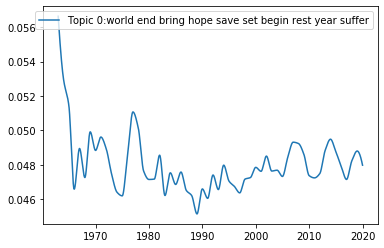

In [99]:
import matplotlib.pyplot as plt

%matplotlib inline 

topic_labels = 'Topic {}:'.format(TOPIC2PLOT) + ' '.join([word[0] for word in lda.show_topic(TOPIC2PLOT, 10)])
plt.plot(x_smooth,y_smooth, label=topic_labels)
plt.legend()